In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
from pydpmd.utils import split_systems, join_systems
import matplotlib.pyplot as plt
import numpy as np
import os
from mode_resources import *
from local_sim import *

In [2]:
p = '/Users/marshallmccraw/Projects/yale/data/f-25/09-01-25/disk-jamming-large/disk/jamming_0'
# p = '/Users/marshallmccraw/Projects/yale/data/f-25/09-01-25/disk-jamming-small/disk/jamming_0'
data = dp.data.load(p, location=['final', 'init'])
data = split_systems(data)[0]

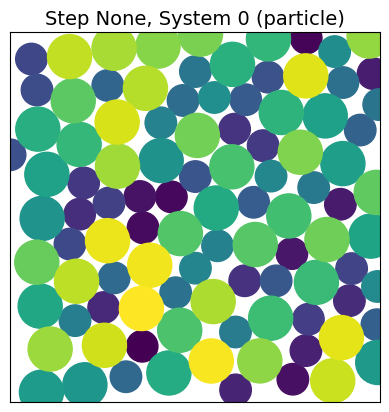

In [3]:
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', None)

In [4]:
H_disk, M_disk, val_disk, vec_disk, non_rattler_ids_disk = get_dynamical_matrix_modes_for_disk(data)
H = H_disk[0]
M = M_disk[0]
val = val_disk[0]
vec = vec_disk[0]
N = H.shape[0] // 2

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:30<00:00, 30.82s/it]


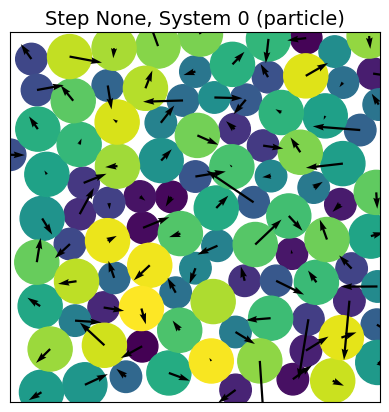

In [5]:
i = 2
u_i = val[i]
v_i = np.column_stack((vec[:N, i], vec[N:, i]))
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', None)
plt.quiver(np.mod(data.pos[non_rattler_ids_disk, 0], data.box_size[0, 0]), np.mod(data.pos[non_rattler_ids_disk, 1], data.box_size[0, 1]), v_i[:, 0], v_i[:, 1])

In [6]:
temperature = 1e-10
delta_phi = -1e-4

pos = data.pos[non_rattler_ids_disk][0].copy()
radii = data.rad[non_rattler_ids_disk][0].copy()
mass = data.rad[non_rattler_ids_disk][0].copy()
box_size = data.box_size[0].copy()

vec_all = np.sum(vec[:, 2:], axis=1)
vec_all = np.column_stack((vec_all[:N], vec_all[N:]))
vel = vec_all.copy()
scale = np.sqrt(temperature / (np.sum(mass * np.sum(vel ** 2, axis=1)) / (N - 1)))
vel *= scale

phi = np.sum(np.pi * radii ** 2) / np.prod(box_size)
phi = phi + delta_phi
new_box_size = np.sqrt(np.sum(np.pi * radii ** 2) / (phi)) * np.ones_like(box_size)
scale = new_box_size / box_size
box_size *= scale
pos *= scale

In [28]:
N_steps = 100000
N_save_steps = 100000
k = 1.0
dt = 1e-2

verlet_skin = 0.5
verlet_cutoff = 2 * np.max(data.rad) * (1 + verlet_skin)
displacement = np.zeros_like(data.rad)

neighbors_i, neighbors_j = build_neighbor_list(pos, box_size, verlet_cutoff)
force, pe = compute_forces_numba(pos, radii, k, neighbors_i, neighbors_j, box_size)
disp = np.zeros_like(radii)
last_pos = pos.copy()

pe_total = np.zeros(N_save_steps)
ke_total = np.zeros(N_save_steps)
P = np.zeros((N_save_steps, pos.shape[0], pos.shape[1]))
V = np.zeros((N_save_steps, pos.shape[0], pos.shape[1]))
t = np.zeros_like(pe_total)
F, R = [], []

for i in range(N_steps):
    # update state
    vel += force * dt / (2 * mass[:, None])
    pos += vel * dt
    force, pe = compute_forces_numba(pos, radii, k, neighbors_i, neighbors_j, box_size)
    vel += force * dt / (2 * mass[:, None])

    # update displacements and neighbors if needed
    disp = np.linalg.norm(pos - last_pos, axis=1)
    if np.any(disp > verlet_skin / 2.0):
        neighbors_i, neighbors_j = build_neighbor_list(pos, box_size, verlet_cutoff)
        last_pos = pos.copy()

    # log
    if i % N_steps // N_save_steps == 0:
        t[i] = dt * i
        pe_total[i] = np.sum(pe)
        ke_total[i] = 0.5 * np.sum(mass[:, None] * vel ** 2)
        P[i] = pos
        V[i] = vel
        _F, _R = compute_pairwise_force_matrix(pos, radii, k, neighbors_i, neighbors_j, box_size)
        F.append(_F)
        R.append(_R)

F = np.array(F)
R = np.array(R)

In [ ]:
F_ij = np.linalg.norm(F, axis=-1)
R_ij = np.linalg.norm(R, axis=-1)
sigma_ij = radii[:, None] + radii[None, :]
d_ij = sigma_ij - R_ij

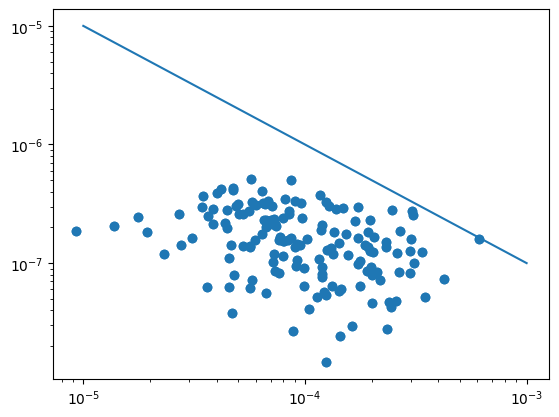

In [ ]:
F_ij_bar = np.mean(F_ij, axis=0)
d_ij_bar = np.mean(d_ij, axis=0)
plt.scatter(-d_ij_bar[F_ij_bar > 0].flatten(), F_ij_bar[F_ij_bar > 0].flatten())
plt.xscale('log')
plt.yscale('log')
x = np.logspace(-3, -5, 10)
plt.plot(x, temperature/x)

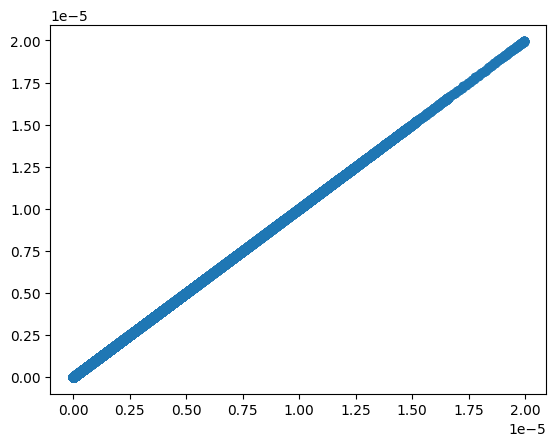

In [12]:
plt.scatter(d_ij[F_ij > 0].flatten(), F_ij[F_ij > 0].flatten())

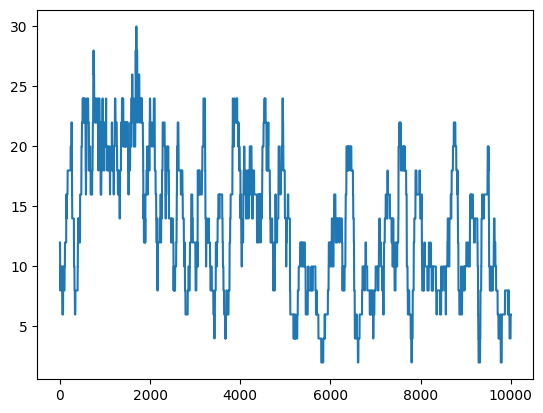

In [55]:
np.sum(F_ij[10] != 0)
plt.plot(np.sum(F_ij != 0, axis=(1, 2)))

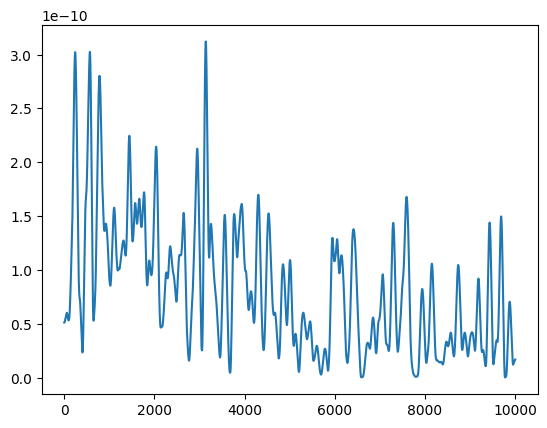

In [56]:
# plt.plot(pe_total + ke_total)
plt.plot(pe_total)
# plt.plot(ke_total)

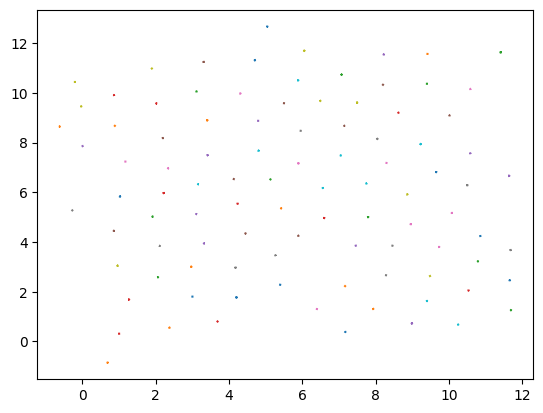

In [52]:
for i in range(pos.shape[0]):
    plt.plot(*P[:, i].T)

In [65]:
U = P - np.mean(P, axis=0)
UU = np.concatenate((U[:, :, 0], U[:, :, 1]), axis=1)
VV = np.concatenate((V[:, :, 0], V[:, :, 1]), axis=1)

C = (UU.T @ UU)
Vc = (VV.T @ VV)

np.linalg.eigh(Vc @ np.linalg.pinv(C))

EighResult(eigenvalues=array([-8.41200920e-01, -2.76818216e-01, -1.88997976e-01, -1.80553531e-01,
       -9.61290548e-02, -7.13288299e-02, -4.23615595e-02, -3.25756144e-02,
       -2.75020700e-02, -2.29635307e-02, -1.69285195e-02, -1.51512335e-02,
       -1.24839461e-02, -1.06494410e-02, -9.78104547e-03, -5.30108669e-03,
       -5.10754743e-03, -4.01215999e-03, -3.21360974e-03, -3.14299628e-03,
       -2.14343386e-03, -1.41289755e-03, -1.35741344e-03, -4.16858632e-04,
       -2.04058670e-04, -3.85323240e-05, -1.44852878e-05, -2.58031271e-06,
       -7.35845460e-11, -3.88999090e-11, -3.12932495e-11, -2.55143911e-11,
       -2.24052577e-11, -2.17808351e-11, -2.16821402e-11, -1.66036253e-11,
       -1.51998423e-11, -1.46077728e-11, -1.42200408e-11, -1.26129402e-11,
       -1.22837139e-11, -1.17459413e-11, -1.12472897e-11, -1.06020571e-11,
       -9.66213185e-12, -9.28752180e-12, -8.03734826e-12, -7.82446205e-12,
       -7.32131298e-12, -6.83830277e-12, -6.29074214e-12, -6.05530446e-12,
  